install `pycocotools`
  - this library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install numpy==1.17

In [3]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

fatal: destination path 'cocoapi' already exists and is not an empty directory.
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycoc

# Writing the Custom Dataset - Penn-Fudan

In [0]:
# writing torch.utils.data.Dataset

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
dataset = CustomDataset('/content/drive/Shared drives/CS 198 & CS199 : Fault-line Assessment/SecondSem/Road Extraction/PennFudanPed')

# Model - Instance Segmentation model for PennFudan Dataset

make model be ready to be trained and evaluated on our custom dataset

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Finished Functions. Run!

Instantiation

 helper functions to simplify training and evaluating detection models

In [7]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7291 (delta 0), reused 2 (delta 0), pack-reused 7289
Receiving objects: 100% (7291/7291), 9.93 MiB | 6.33 MiB/s, done.
Resolving deltas: 100% (4931/4931), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


additional helper functions for data augmentation/transformation
- leverages the functions in references/detection above

Note:
we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Putting Everything Together

In [9]:
# instantiate - dataset class and the data transforms

# use our dataset and defined transformations
dataset = CustomDataset('/content/drive/Shared drives/CS 198 & CS199 : Fault-line Assessment/SecondSem/Road Extraction/PennFudanPed', get_transform(train=True))
dataset_test = CustomDataset('/content/drive/Shared drives/CS 198 & CS199 : Fault-line Assessment/SecondSem/Road Extraction/PennFudanPed', get_transform(train=False))
print(len(dataset))
print(len(dataset_test))

# set percentage of split
train_per = 0.7
valid_per = 0.2
test_per  = 0.1

train_end = int(train_per*len(dataset)) + 1
valid_end = train_end + int(valid_per*len(dataset))
test_end  = valid_end + int(test_per*len(dataset))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:train_end])
dataset_valid = torch.utils.data.Subset(dataset_test, indices[train_end:valid_end])
dataset_test = torch.utils.data.Subset(dataset_test, indices[valid_end:])

print(len(dataset))
print(len(dataset_valid))
print(len(dataset_test))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

170
170
119
34
17


In [10]:
#instantiate - model and the optimizer

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


Train model

In [11]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)

Epoch: [0]  [ 0/60]  eta: 0:04:25  lr: 0.000090  loss: 4.4839 (4.4839)  loss_classifier: 0.7029 (0.7029)  loss_box_reg: 0.2665 (0.2665)  loss_mask: 3.4846 (3.4846)  loss_objectness: 0.0106 (0.0106)  loss_rpn_box_reg: 0.0194 (0.0194)  time: 4.4196  data: 3.0488  max mem: 2710
Epoch: [0]  [10/60]  eta: 0:00:55  lr: 0.000936  loss: 1.6075 (2.0914)  loss_classifier: 0.4538 (0.4573)  loss_box_reg: 0.1572 (0.1596)  loss_mask: 0.9859 (1.4405)  loss_objectness: 0.0195 (0.0215)  loss_rpn_box_reg: 0.0114 (0.0125)  time: 1.1074  data: 0.6427  max mem: 2978
Epoch: [0]  [20/60]  eta: 0:00:35  lr: 0.001783  loss: 0.7829 (1.4251)  loss_classifier: 0.2750 (0.3290)  loss_box_reg: 0.1306 (0.1601)  loss_mask: 0.4456 (0.9001)  loss_objectness: 0.0195 (0.0210)  loss_rpn_box_reg: 0.0114 (0.0149)  time: 0.7160  data: 0.3592  max mem: 2978
Epoch: [0]  [30/60]  eta: 0:00:28  lr: 0.002629  loss: 0.5370 (1.1282)  loss_classifier: 0.1196 (0.2535)  loss_box_reg: 0.1507 (0.1608)  loss_mask: 0.2340 (0.6801)  loss_ob

Predict

In [12]:
model.eval()
with torch.no_grad():
  evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/17]  eta: 0:00:04  model_time: 0.0848 (0.0848)  evaluator_time: 0.0038 (0.0038)  time: 0.2846  data: 0.1944  max mem: 3596
Test:  [16/17]  eta: 0:00:00  model_time: 0.0733 (0.0755)  evaluator_time: 0.0038 (0.0053)  time: 0.0961  data: 0.0139  max mem: 3596
Test: Total time: 0:00:01 (0.0999 s / it)
Averaged stats: model_time: 0.0733 (0.0755)  evaluator_time: 0.0038 (0.0053)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.996
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.601
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

In [13]:
import cv2
from google.colab.patches import cv2_imshow


for i in range(len(dataset_test)):
  print(i)
  img, _ = dataset_test[i]
  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])
  img = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
  name = 'img_' + str(i) + '.jpg'
  cv2.imwrite(name, img)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


Results

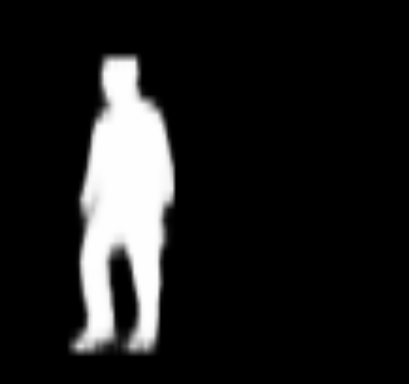

In [14]:
# sample results
import cv2
from google.colab.patches import cv2_imshow
img = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
cv2_imshow(img)

In [0]:
# see output_pennfudan for the other output picture